In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib
import matplotlib.pyplot as plt

from dataset import WordDataset
from models import Wan, Han
from config import BATCH_SIZE, DEVICE, WORD_HIDDEN_SIZE, Yelp

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [16, 13]

In [2]:
df = pd.read_csv("data/yelp_test.csv").fillna("")
wv = KeyedVectors.load("embedding/yelp.wv")
dataset = WordDataset(df.text, df.label, wv.vocab, 15)
model = Wan(
    embedding_matrix=wv.vectors,
    word_hidden_size=WORD_HIDDEN_SIZE,
    num_classes=len(df.label.unique()),
    batch_size=1,
)
model.load_state_dict(
    torch.load("models/yelp-wan-20200422-152139.pth", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [3]:
label, doc = dataset[62]
print(f"Label: {label}")
tokens = [wv.index2word[i] for i in doc]
print(" ".join(tokens))

Label: 3
good place for breakfast/brunch . sleek decoration . fresh food . good service PAD PAD


In [4]:
prediction = model(torch.LongTensor(doc).unsqueeze(0)).argmax(1).item()
print(f"Predicted label: {prediction}")

Predicted label: 3


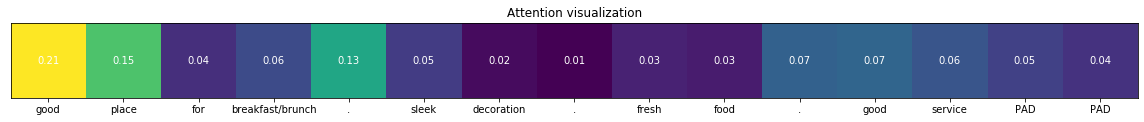

In [12]:
fig, ax = plt.subplots()
im = ax.imshow([model.word_attention.last_weights])
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_title("Attention visualization")


# Add attention weight in each rectangle
for i in range(len(tokens)):
    ax.text(
        i, 0, round(model.word_attention.last_weights[i], 2), ha="center", va="center", color="w"
    )
    
# Remove y ticks
ax.yaxis.set_major_locator(plt.NullLocator())

fig.tight_layout()

In [6]:
model.word_attention.last_weights

[0.20665067434310913,
 0.15173140168190002,
 0.036578286439180374,
 0.05516770854592323,
 0.12684839963912964,
 0.04506660997867584,
 0.01647718995809555,
 0.010495677590370178,
 0.029297783970832825,
 0.025772487744688988,
 0.07114111632108688,
 0.07479581981897354,
 0.062396466732025146,
 0.04827486723661423,
 0.03930554538965225]

In [ ]:
from collections import Counter

for i in range(0, 1000):
    _, doc = dataset[i]
    if Counter(doc)[0] == 2:
        print(i)
        break